# Task 9 – Explainable AI for Transformers

In this notebook, I apply Explainable AI (XAI) techniques to interpret the decisions made by my fine-tuned Transformer model (`bert_large_8`). This task is based on the paper *"XAI for Transformers: Better Explanations through Conservative Propagation"* by Ali et al. (2022).

The notebook is divided into three main parts:
1. **Gradient × Input**: Basic relevance attribution
2. **Conservative Layer-wise Relevance Propagation (LRP)**: Improved explanation with attention and normalization propagation
3. **Input Perturbation**: Evaluate model robustness by token removal

----------------------------------

# PART 1 – Gradient × Input Explanations

### Imports

In [1]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
# Load your fine-tuned BERT model
tokenizer = AutoTokenizer.from_pretrained("bert_large_8")
model = AutoModelForSequenceClassification.from_pretrained("bert_large_8")

2025-04-03 11:50:38.685995: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-03 11:50:38.699111: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743681038.713608   72355 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743681038.718023   72355 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743681038.730433   72355 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
def gradient_x_input(model, inputs):
    # Get embeddings from input IDs
    inputs_embeds = model.get_input_embeddings()(inputs.input_ids)
    inputs_embeds = inputs_embeds.clone().detach().requires_grad_(True)

    # Forward pass
    outputs = model(inputs_embeds=inputs_embeds, attention_mask=inputs.attention_mask)
    logits = outputs.logits
    predicted_class = logits.argmax(dim=-1)

    # Backward pass to get gradients wrt predicted class
    logits[:, predicted_class].backward()

    # Relevance = gradient × input
    if inputs_embeds.grad is None:
        raise RuntimeError("Gradients not computed properly.")
    
    return inputs_embeds.grad * inputs_embeds

In [4]:
# Load the test dataset
df = pd.read_excel("group_24_url1_mapped 1.xlsx")

# Select 3 samples per emotion
selected = defaultdict(list)
for _, row in df.iterrows():
    emotion = row["adjusted_label"]
    if len(selected[emotion]) < 3:
        selected[emotion].append(row["Translation"])  
    if all(len(samples) == 3 for samples in selected.values()) and len(selected) == 7:
        break

# Flatten into list of (text, label) pairs
selected_examples = []
for label, texts in selected.items():
    for text in texts:
        selected_examples.append((text, label))

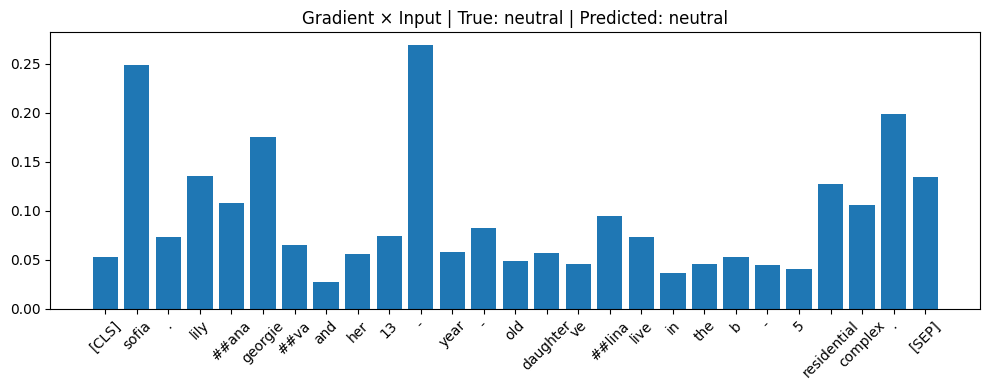

Sentence: Sofia. Lilyana Georgieva and her 13-year-old daughter Velina live in the B-5 residential complex.
True Label: neutral
Predicted: neutral
--------------------------------------------------------------------------------


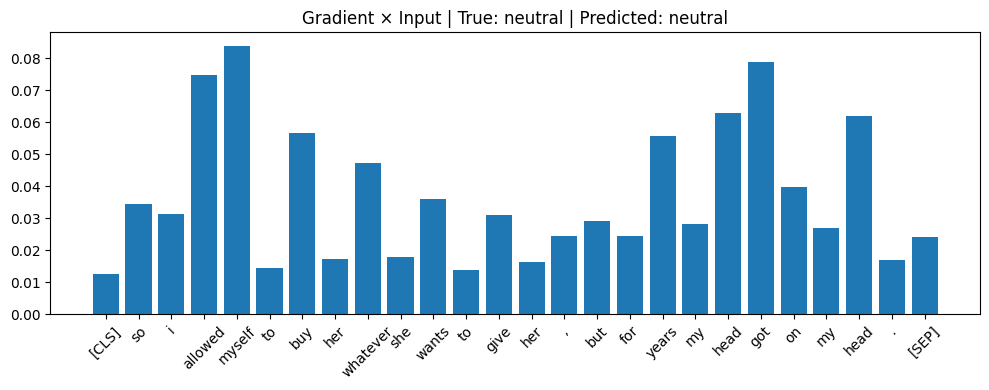

Sentence: So I allowed myself to buy her whatever she wants to give her, but for years my head got on my head.
True Label: neutral
Predicted: neutral
--------------------------------------------------------------------------------


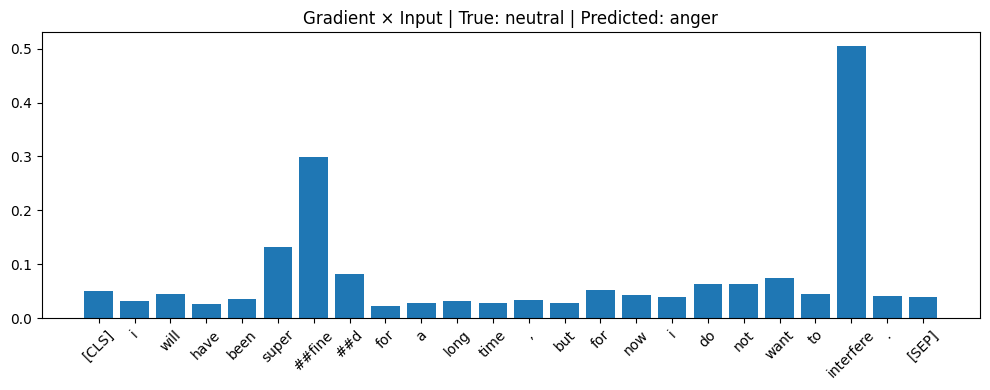

Sentence: I will have been superfined for a long time, but for now I do not want to interfere.
True Label: neutral
Predicted: anger
--------------------------------------------------------------------------------


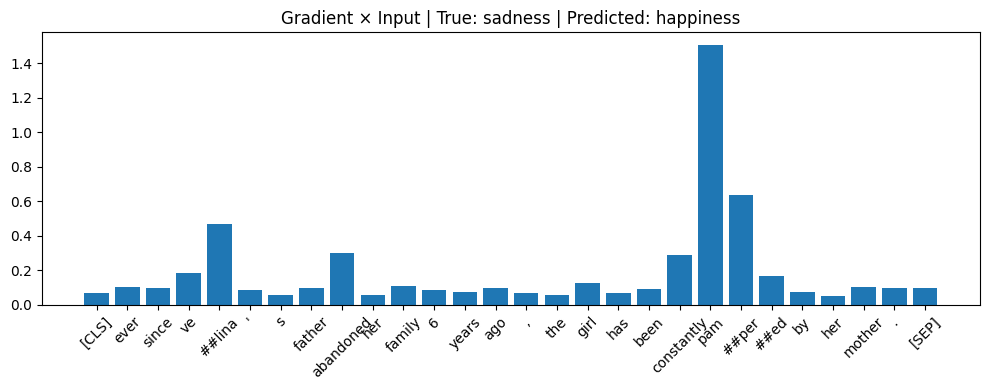

Sentence: Ever since Velina's father abandoned her family 6 years ago, the girl has been constantly pampered by her mother.
True Label: sadness
Predicted: happiness
--------------------------------------------------------------------------------


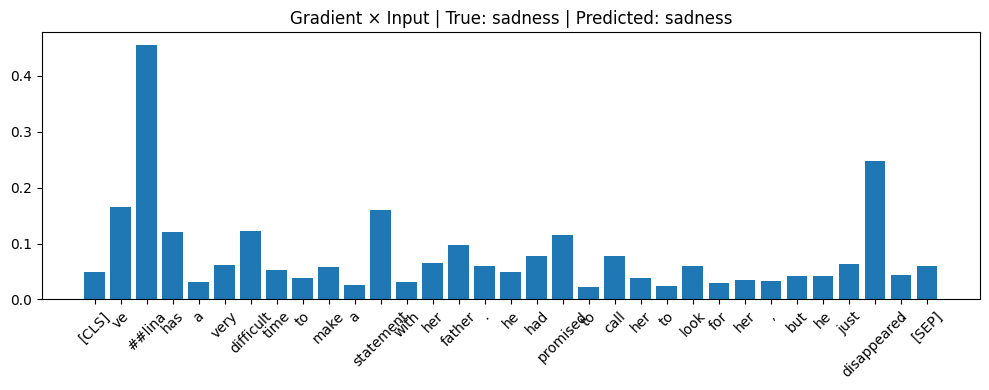

Sentence: Velina has a very difficult time to make a statement with her father. He had promised to call her to look for her, but he just disappeared.
True Label: sadness
Predicted: sadness
--------------------------------------------------------------------------------


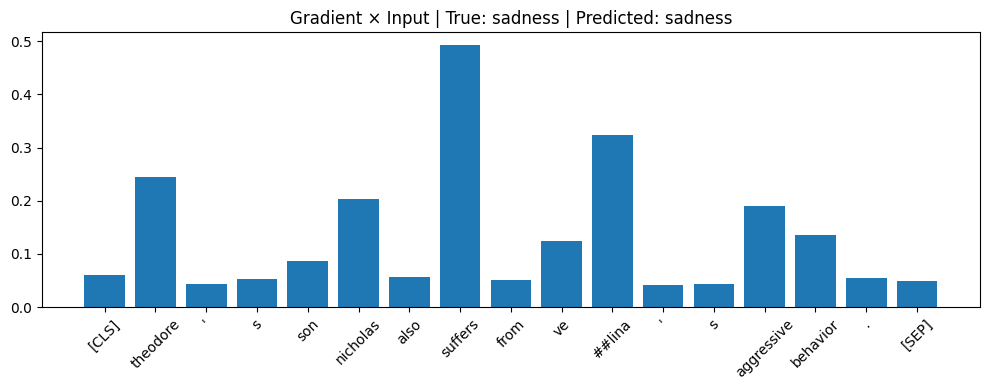

Sentence: Theodore's son Nicholas also suffers from Velina's aggressive behavior.
True Label: sadness
Predicted: sadness
--------------------------------------------------------------------------------


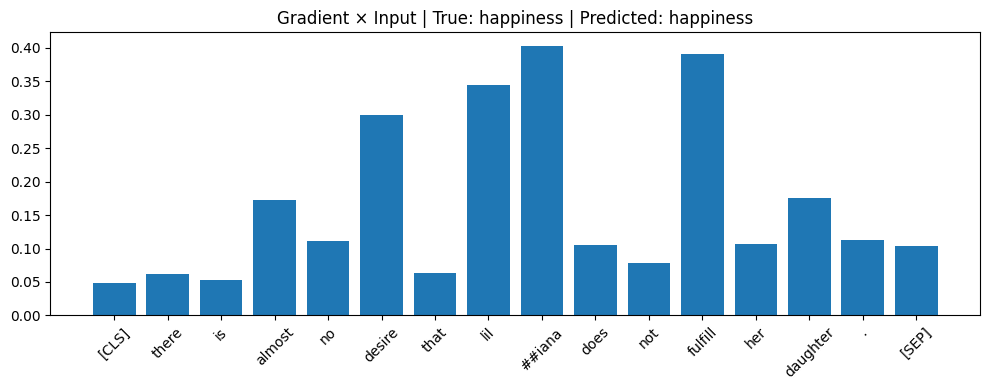

Sentence: There is almost no desire that Liliana does not fulfill her daughter.
True Label: happiness
Predicted: happiness
--------------------------------------------------------------------------------


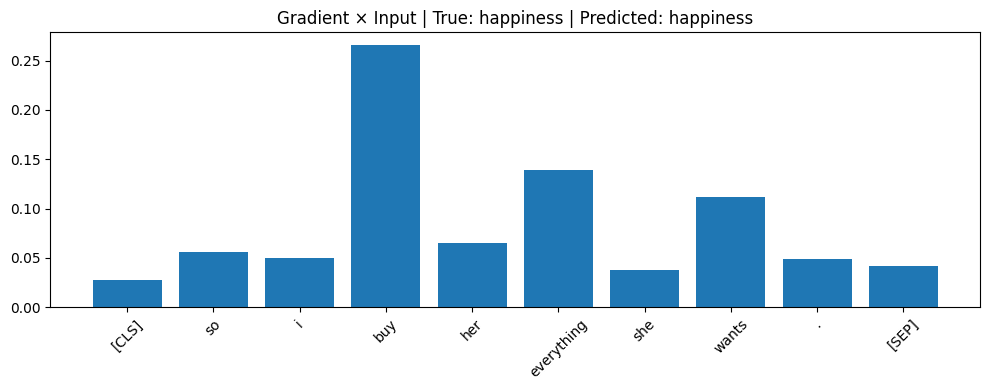

Sentence: So I buy her everything she wants.
True Label: happiness
Predicted: happiness
--------------------------------------------------------------------------------


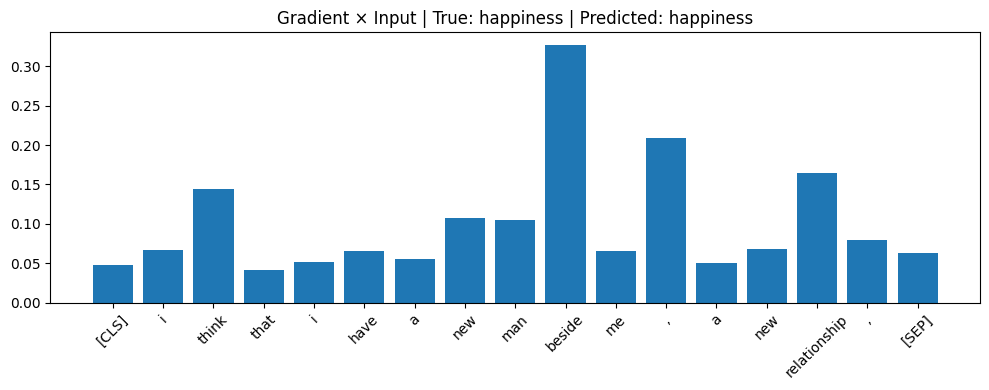

Sentence: I think that I have a new man beside me, a new relationship,
True Label: happiness
Predicted: happiness
--------------------------------------------------------------------------------


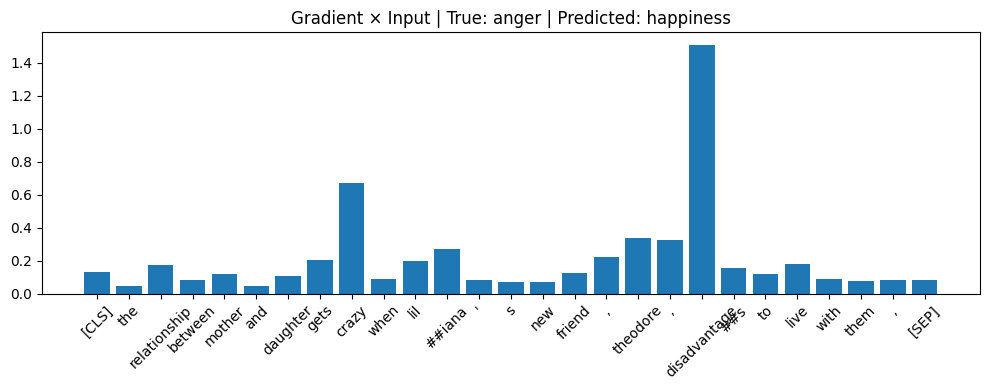

Sentence: The relationship between mother and daughter gets crazy when Liliana's new friend, Theodore, disadvantages to live with them,
True Label: anger
Predicted: happiness
--------------------------------------------------------------------------------


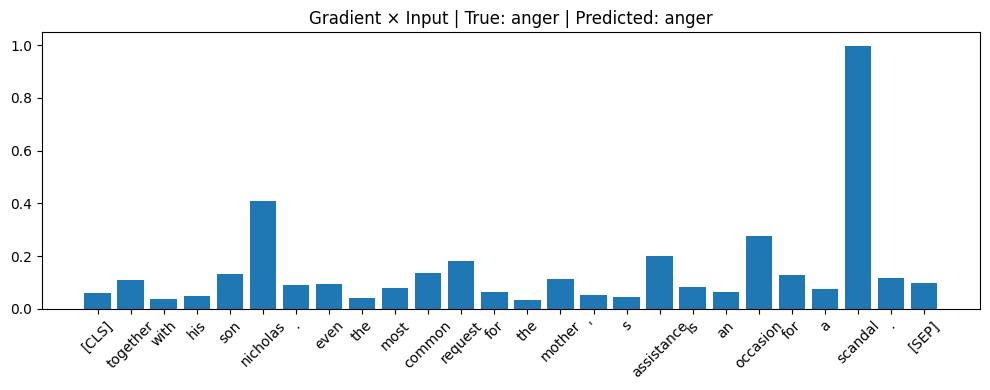

Sentence: Together with his son Nicholas. Even the most common request for the mother's assistance is an occasion for a scandal.
True Label: anger
Predicted: anger
--------------------------------------------------------------------------------


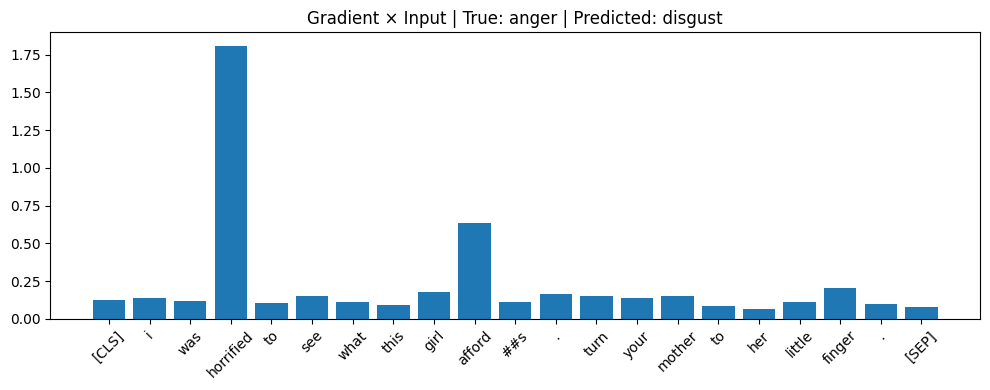

Sentence: I was horrified to see what this girl affords. Turn your mother to her little finger.
True Label: anger
Predicted: disgust
--------------------------------------------------------------------------------


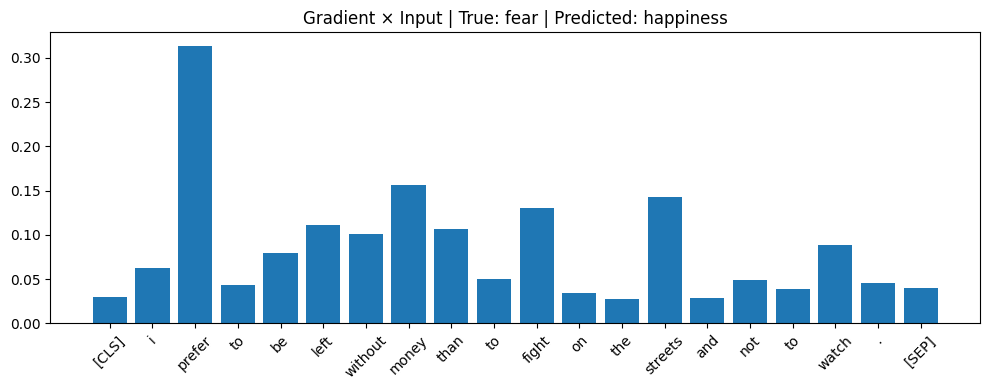

Sentence: I prefer to be left without money than to fight on the streets and not to watch.
True Label: fear
Predicted: happiness
--------------------------------------------------------------------------------


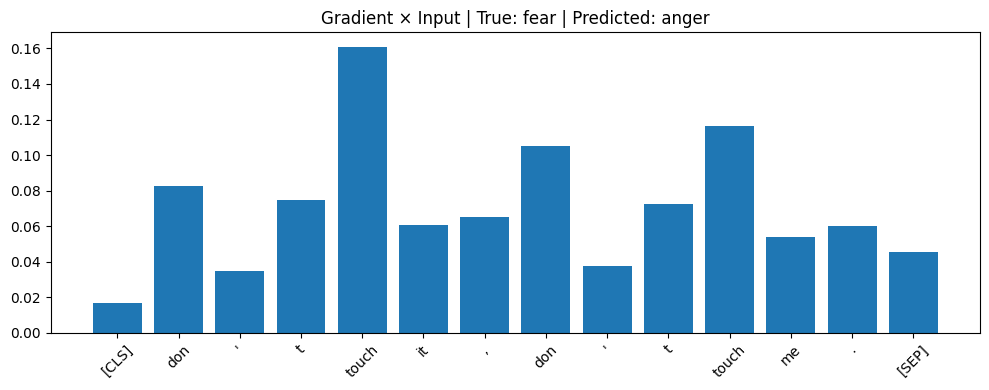

Sentence: Don't touch it, don't touch me.
True Label: fear
Predicted: anger
--------------------------------------------------------------------------------


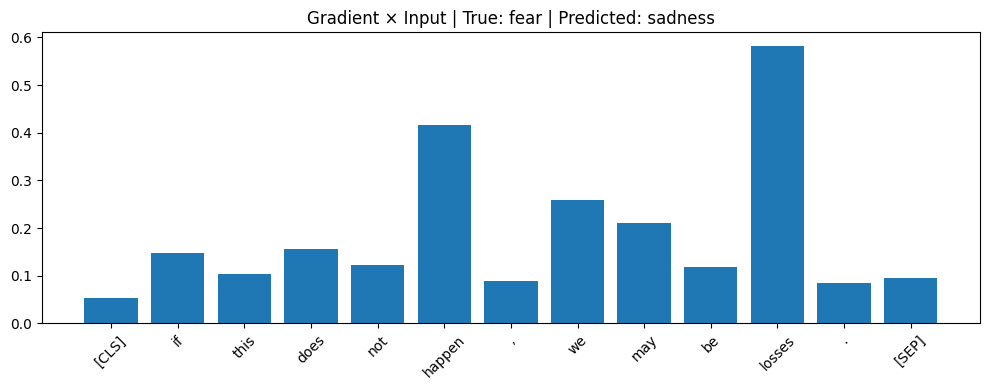

Sentence: If this does not happen, we may be losses.
True Label: fear
Predicted: sadness
--------------------------------------------------------------------------------


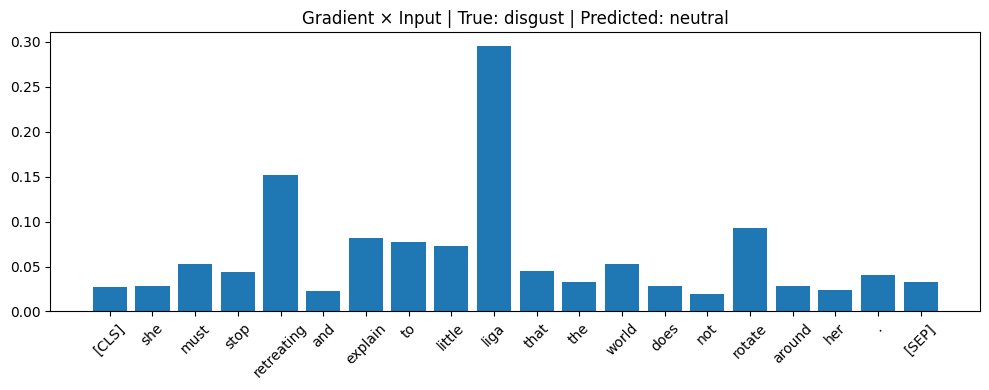

Sentence: She must stop retreating and explain to Little Liga that the world does not rotate around her.
True Label: disgust
Predicted: neutral
--------------------------------------------------------------------------------


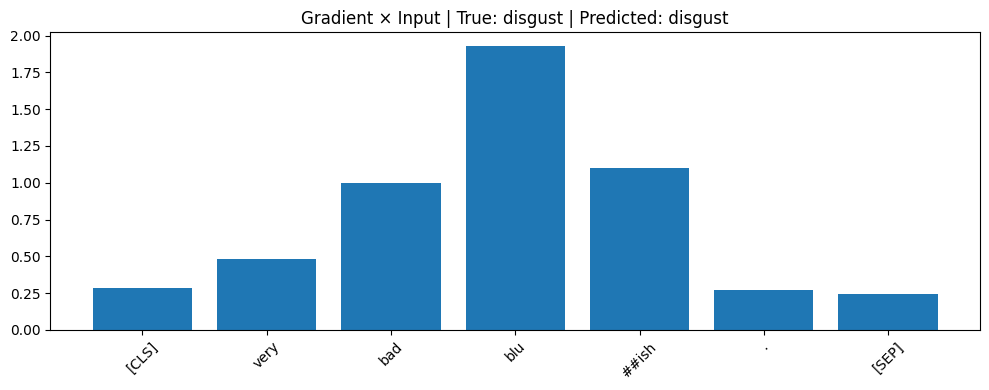

Sentence: Very bad bluish.
True Label: disgust
Predicted: disgust
--------------------------------------------------------------------------------


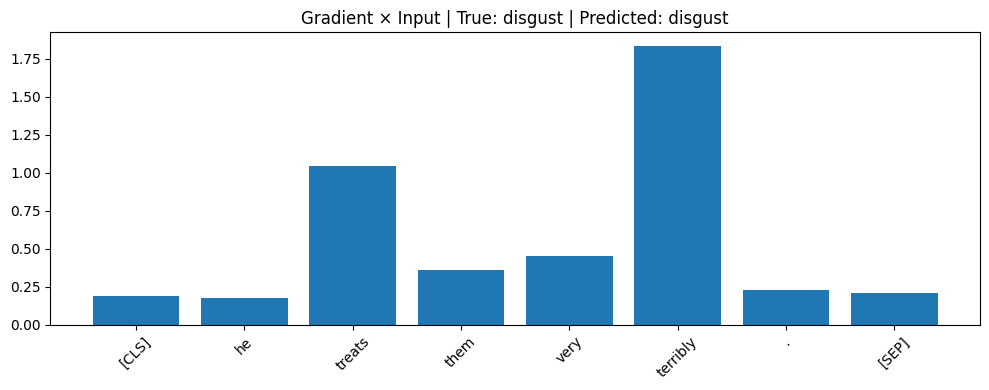

Sentence: He treats them very terribly.
True Label: disgust
Predicted: disgust
--------------------------------------------------------------------------------


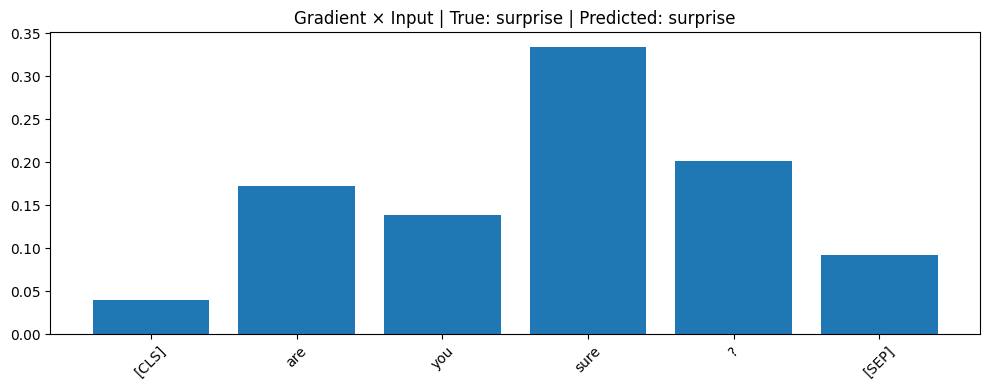

Sentence: Are you sure?
True Label: surprise
Predicted: surprise
--------------------------------------------------------------------------------


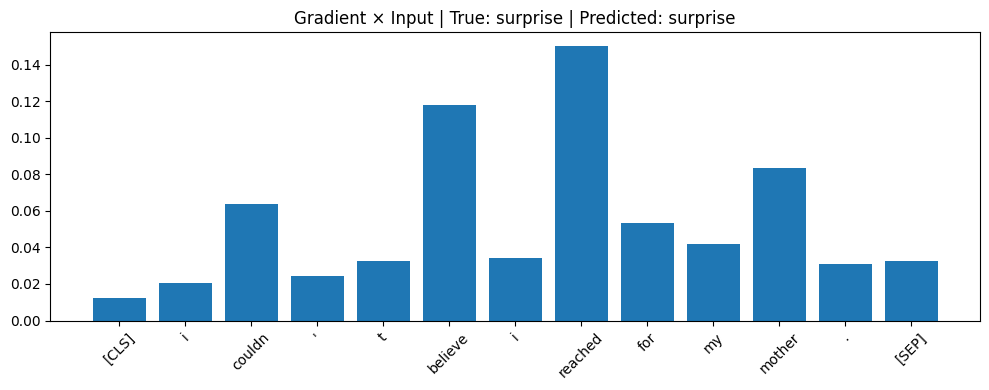

Sentence: I couldn't believe I reached for my mother.
True Label: surprise
Predicted: surprise
--------------------------------------------------------------------------------


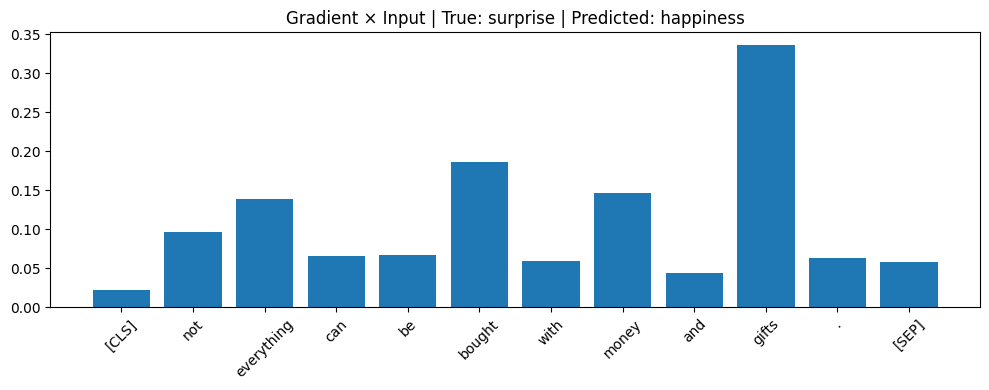

Sentence: Not everything can be bought with money and gifts.
True Label: surprise
Predicted: happiness
--------------------------------------------------------------------------------


In [5]:
# Loop through all selected examples
for text, true_label in selected_examples:
    # Tokenize and get inputs
    inputs = tokenizer(text, return_tensors='pt')
    relevance = gradient_x_input(model, inputs)

    # Convert tokens and relevance scores
    tokens = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
    token_scores = relevance.norm(dim=-1).squeeze().detach().numpy()

    # Predict emotion
    outputs = model(**inputs)
    pred_label = model.config.id2label[outputs.logits.argmax(dim=-1).item()]

    # Plot
    plt.figure(figsize=(10, 4))
    plt.bar(range(len(tokens)), token_scores)
    plt.xticks(range(len(tokens)), tokens, rotation=45)
    plt.title(f"Gradient × Input | True: {true_label} | Predicted: {pred_label}")
    plt.tight_layout()
    plt.show()

    print(f"Sentence: {text}")
    print(f"True Label: {true_label}")
    print(f"Predicted: {pred_label}")
    print("-" * 80)

## Part 1 – Reflection on Gradient × Input Explanations

In this section, we used the Gradient × Input method to understand which tokens the model focused on when predicting emotions. Each sentence was broken down into token-level relevance scores, and we visualized these as bar plots.

### What we observed:

- In most cases, the model assigned higher importance to words that clearly carry emotional meaning. This suggests it’s often picking up on the right signals when making predictions.

- The highlighted tokens generally matched what we, as humans, would also find emotionally important. This was especially noticeable when strong emotional words stood out clearly in the plot.

- Even when the model made a mistake, the words it focused on still made sense emotionally. That makes the misclassifications easier to understand and interpret.

- Overall, Gradient × Input gave us a useful first look into how the model is making decisions. While it's a simple method, it already provides some insight into whether the model is "looking" at the right parts of the sentence.

------------------------------------

# Part 2: Conservative Propagation (LRP)

## Part 2 – Improved Explanation with Conservative Propagation (Layer-wise Relevance Propagation)

The Gradient × Input method has its limitations, especially when applied to complex models like Transformers, where many hidden layers and attention heads interact in non-transparent ways.

In this part, we apply a more advanced explanation technique based on **Layer-wise Relevance Propagation (LRP)** using the **Conservative Propagation** method proposed by Ali et al. (2022).

To do this, we modify the model's internal computations:
- In **self-attention**, we detach the softmax output so that the relevance is propagated independently from dynamic attention weights.
- In **LayerNorm**, we detach the normalization factor to allow better control over how relevance spreads through the network.

We'll re-run the relevance explanation for the same 21 sentences and generate new bar plots. The results will then be compared to those from Gradient × Input to evaluate whether LRP provides more meaningful or focused token-level explanations.

In [6]:
# Modified Attention Layer for Conservative Propagation
def modified_attention_forward(hidden_states, relevance_scores):
    # Compute attention scores and softmax
    attention_scores = (hidden_states @ hidden_states.transpose(-1, -2)) / hidden_states.size(-1) ** 0.5
    attention_probs = attention_scores.softmax(dim=-1).detach()  # Detach softmax (AH-rule)

    # Context computation
    context_layer = attention_probs @ hidden_states

    # Relevance redistribution
    propagated_relevance = (attention_probs.transpose(-1, -2) @ relevance_scores)
    return context_layer, propagated_relevance


# Modified LayerNorm for Conservative Propagation
def modified_layernorm_forward(hidden_states, relevance_scores, eps=1e-12):
    mean = hidden_states.mean(-1, keepdim=True)
    variance = hidden_states.var(-1, keepdim=True, unbiased=False)
    normed = (hidden_states - mean) / (variance + eps).sqrt()

    # Relevance redistribution with detached normalization
    propagated_relevance = relevance_scores / (variance + eps).sqrt()
    return normed.detach(), propagated_relevance

In [7]:
def lrp_conservative_propagation(model, tokenizer, text, max_layers=3):
    # Tokenize input
    inputs = tokenizer(text, return_tensors='pt')
    input_ids = inputs.input_ids
    attention_mask = inputs.attention_mask

    # Get embeddings and hidden states
    inputs_embeds = model.get_input_embeddings()(input_ids)
    hidden_states = inputs_embeds.clone().detach().requires_grad_(True)

    # Forward pass
    outputs = model(inputs_embeds=hidden_states, attention_mask=attention_mask)
    logits = outputs.logits
    pred_class = logits.argmax(dim=-1)

    # Start relevance from the logit of the predicted class
    relevance_scores = torch.zeros_like(hidden_states)
    relevance_scores[:, -1, :] = logits[:, pred_class].unsqueeze(-1)

    # Propagate through BERT layers
    for i in reversed(range(max_layers)):
        layer = model.bert.encoder.layer[i]
        attention = layer.attention.self
        layernorm = layer.output.LayerNorm

        # Step 1: Attention
        context, relevance_scores = modified_attention_forward(hidden_states, relevance_scores)

        # Step 2: Feedforward and residual (simplified for relevance backprop)
        relevance_scores = relevance_scores + hidden_states  # Add residual connection

        # Step 3: LayerNorm
        hidden_states, relevance_scores = modified_layernorm_forward(hidden_states, relevance_scores)

    # Final relevance norm per token
    token_relevance = relevance_scores.norm(dim=-1).squeeze().detach().numpy()
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze())

    return tokens, token_relevance, model.config.id2label[pred_class.item()], text    

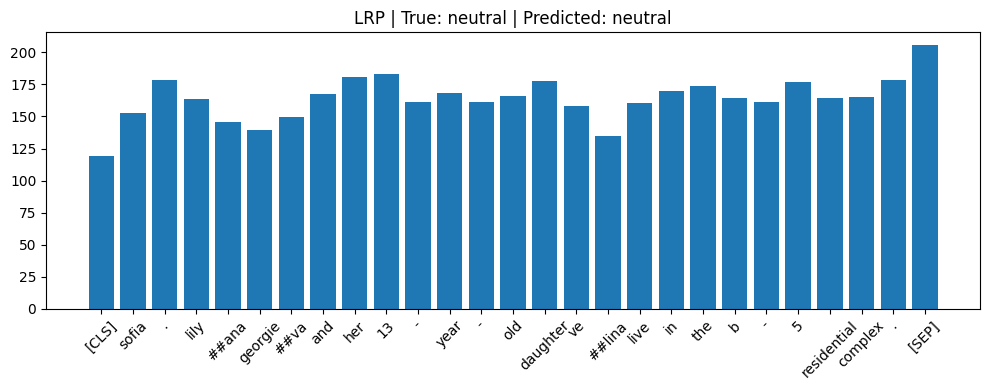

Sentence: Sofia. Lilyana Georgieva and her 13-year-old daughter Velina live in the B-5 residential complex.
True Label: neutral
Predicted Label: neutral
--------------------------------------------------------------------------------


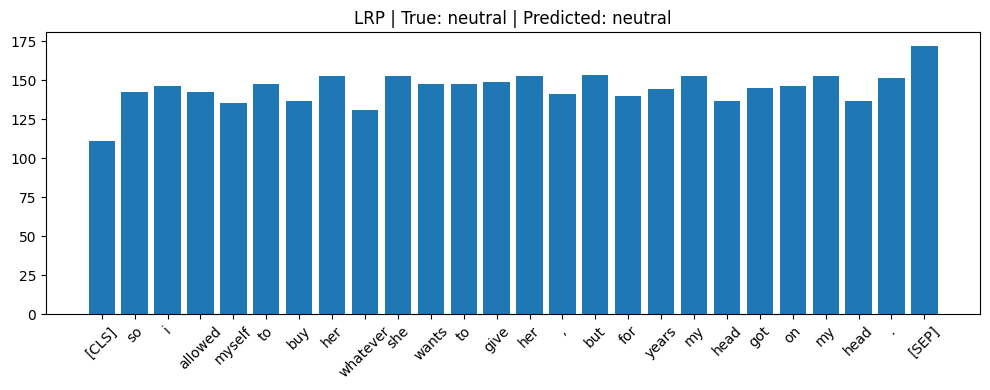

Sentence: So I allowed myself to buy her whatever she wants to give her, but for years my head got on my head.
True Label: neutral
Predicted Label: neutral
--------------------------------------------------------------------------------


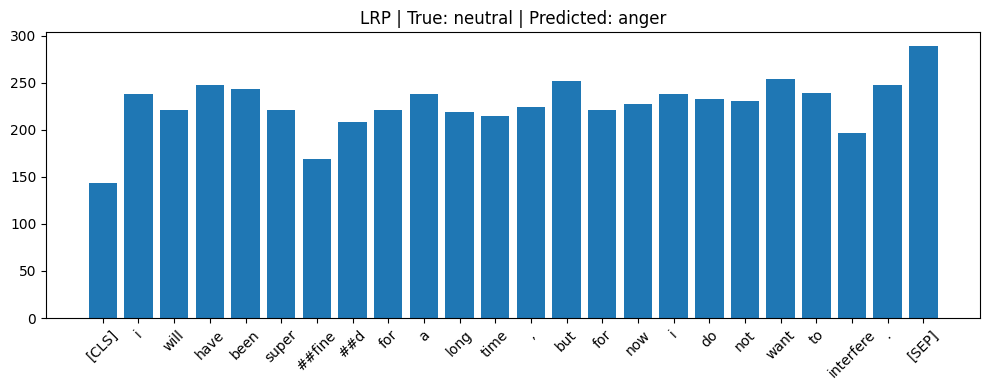

Sentence: I will have been superfined for a long time, but for now I do not want to interfere.
True Label: neutral
Predicted Label: anger
--------------------------------------------------------------------------------


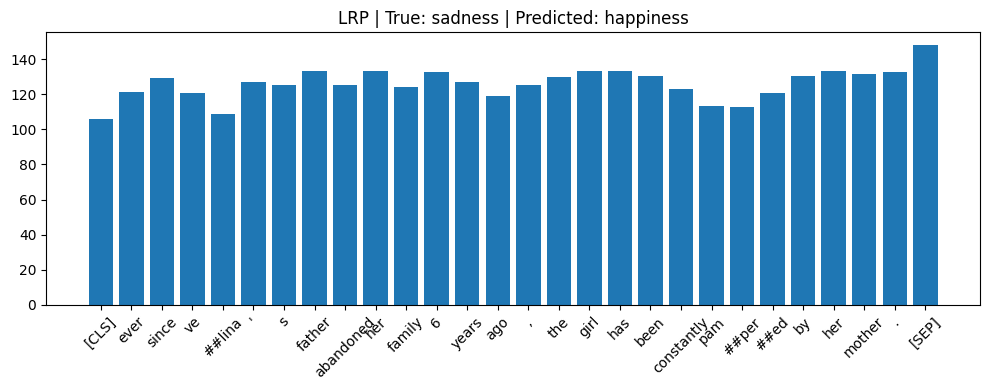

Sentence: Ever since Velina's father abandoned her family 6 years ago, the girl has been constantly pampered by her mother.
True Label: sadness
Predicted Label: happiness
--------------------------------------------------------------------------------


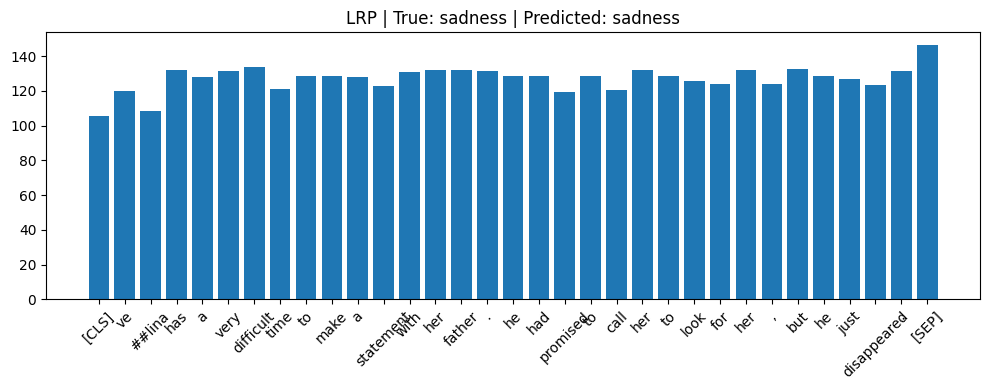

Sentence: Velina has a very difficult time to make a statement with her father. He had promised to call her to look for her, but he just disappeared.
True Label: sadness
Predicted Label: sadness
--------------------------------------------------------------------------------


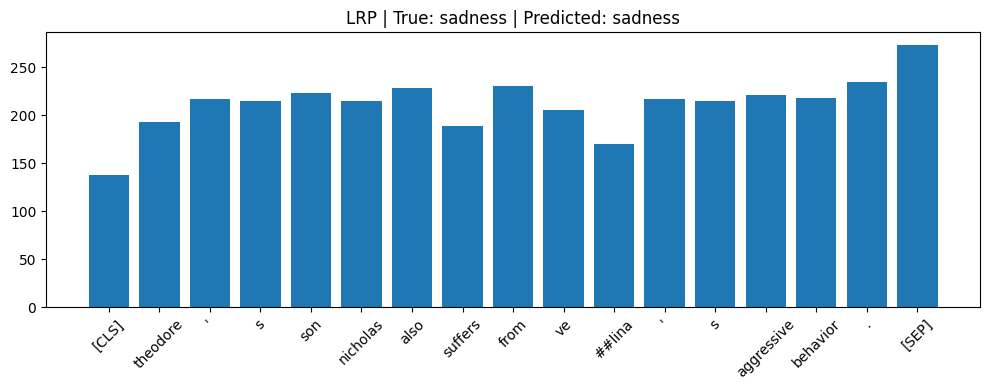

Sentence: Theodore's son Nicholas also suffers from Velina's aggressive behavior.
True Label: sadness
Predicted Label: sadness
--------------------------------------------------------------------------------


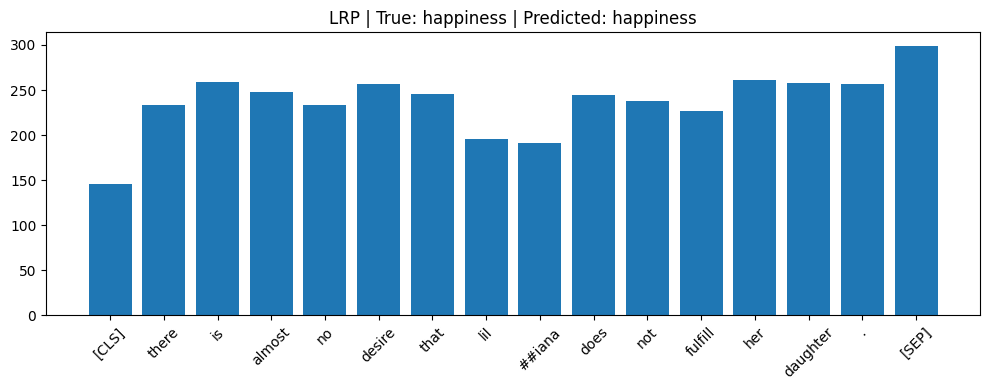

Sentence: There is almost no desire that Liliana does not fulfill her daughter.
True Label: happiness
Predicted Label: happiness
--------------------------------------------------------------------------------


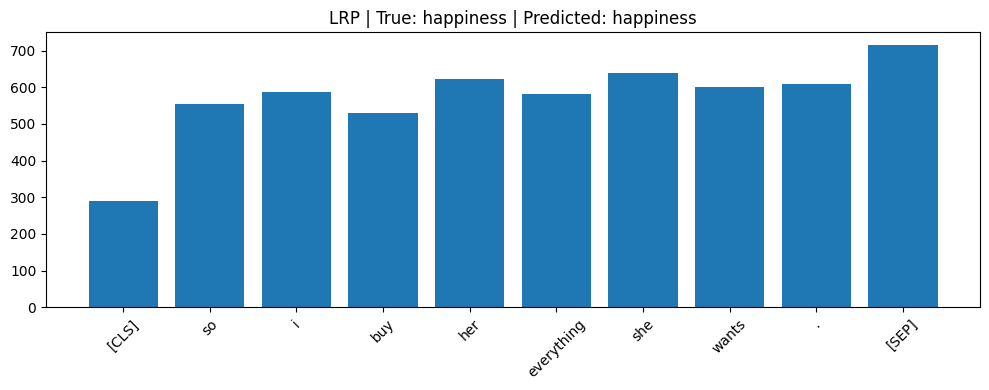

Sentence: So I buy her everything she wants.
True Label: happiness
Predicted Label: happiness
--------------------------------------------------------------------------------


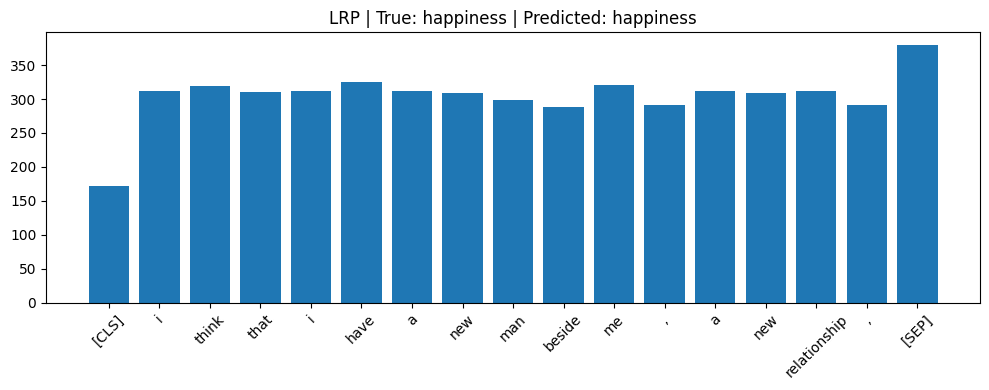

Sentence: I think that I have a new man beside me, a new relationship,
True Label: happiness
Predicted Label: happiness
--------------------------------------------------------------------------------


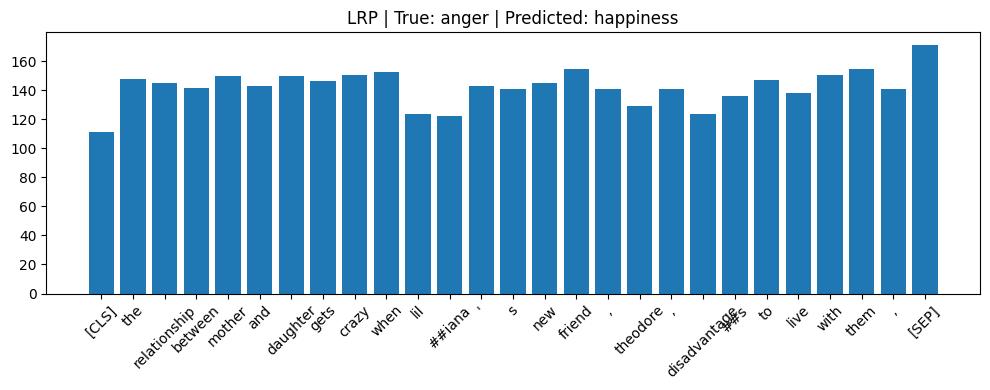

Sentence: The relationship between mother and daughter gets crazy when Liliana's new friend, Theodore, disadvantages to live with them,
True Label: anger
Predicted Label: happiness
--------------------------------------------------------------------------------


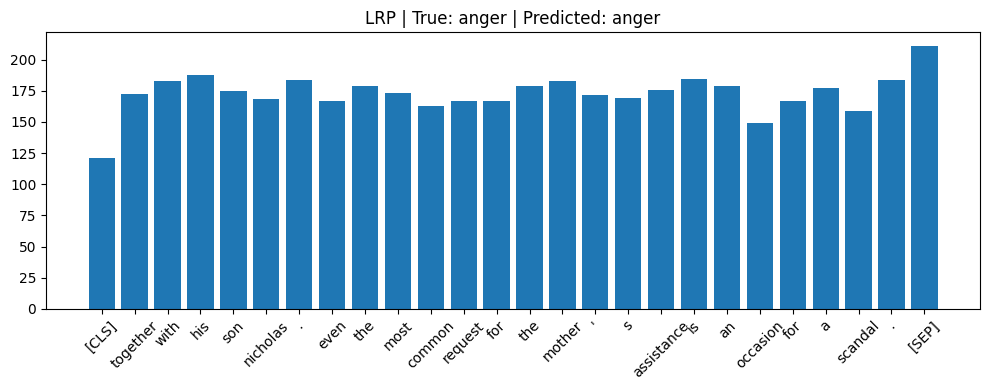

Sentence: Together with his son Nicholas. Even the most common request for the mother's assistance is an occasion for a scandal.
True Label: anger
Predicted Label: anger
--------------------------------------------------------------------------------


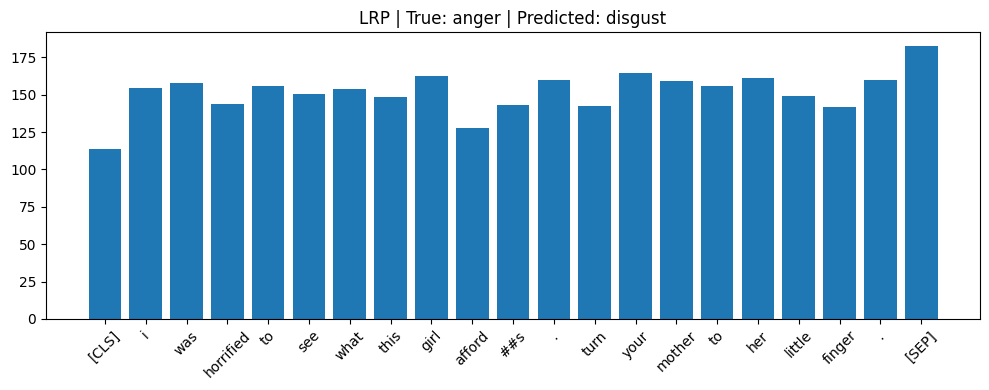

Sentence: I was horrified to see what this girl affords. Turn your mother to her little finger.
True Label: anger
Predicted Label: disgust
--------------------------------------------------------------------------------


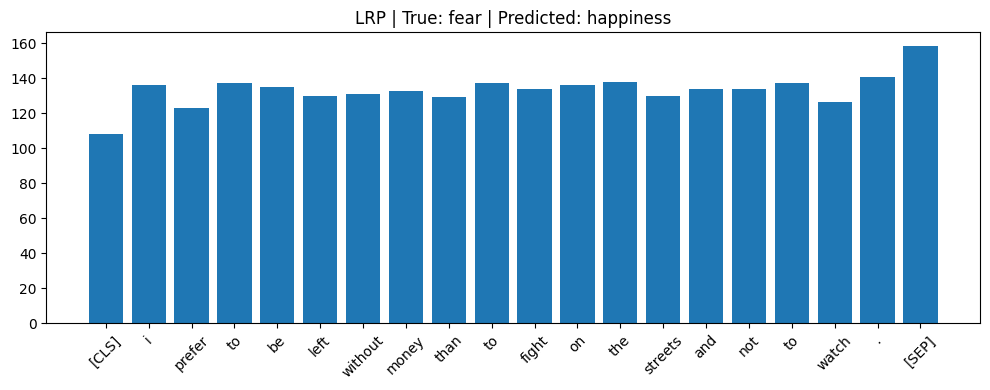

Sentence: I prefer to be left without money than to fight on the streets and not to watch.
True Label: fear
Predicted Label: happiness
--------------------------------------------------------------------------------


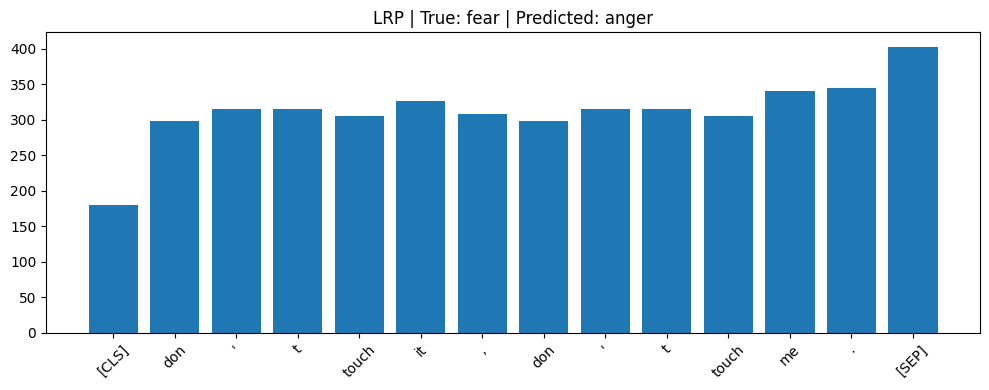

Sentence: Don't touch it, don't touch me.
True Label: fear
Predicted Label: anger
--------------------------------------------------------------------------------


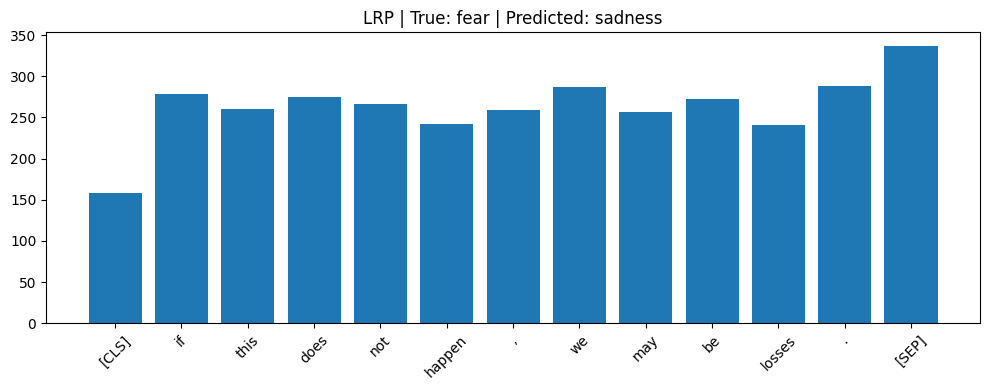

Sentence: If this does not happen, we may be losses.
True Label: fear
Predicted Label: sadness
--------------------------------------------------------------------------------


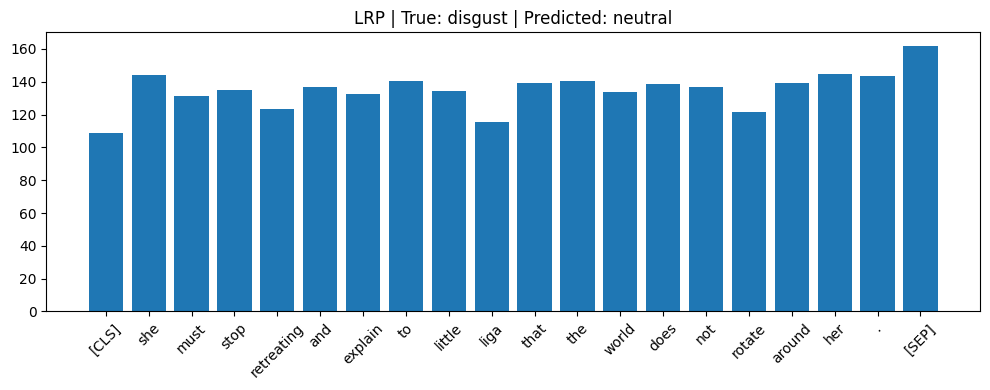

Sentence: She must stop retreating and explain to Little Liga that the world does not rotate around her.
True Label: disgust
Predicted Label: neutral
--------------------------------------------------------------------------------


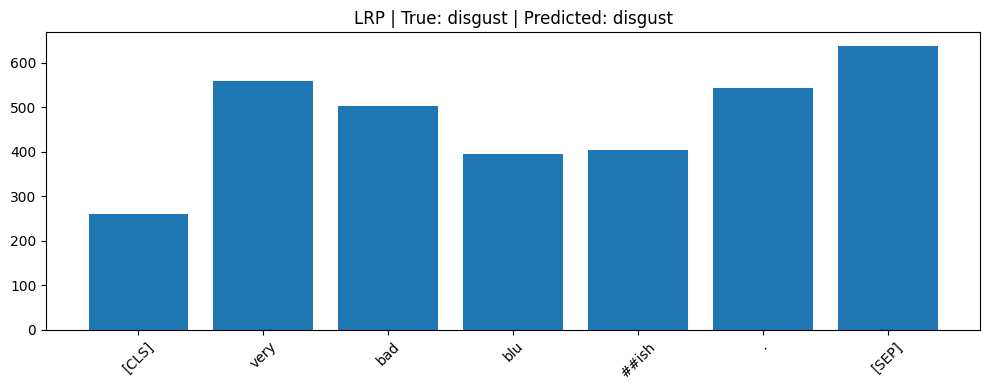

Sentence: Very bad bluish.
True Label: disgust
Predicted Label: disgust
--------------------------------------------------------------------------------


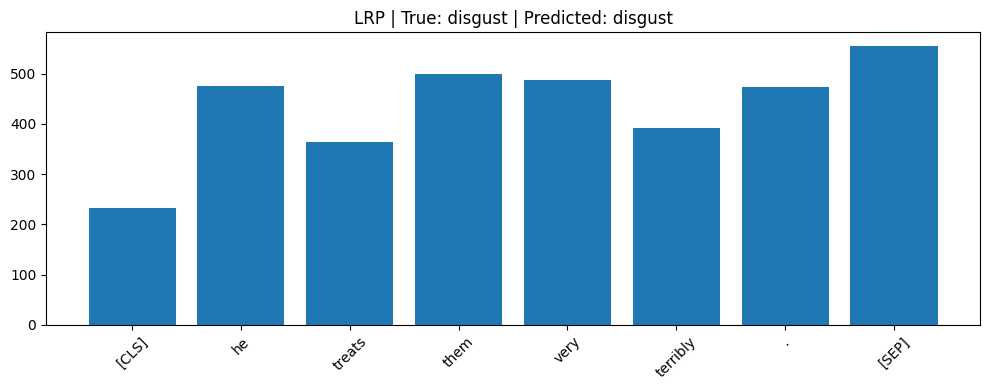

Sentence: He treats them very terribly.
True Label: disgust
Predicted Label: disgust
--------------------------------------------------------------------------------


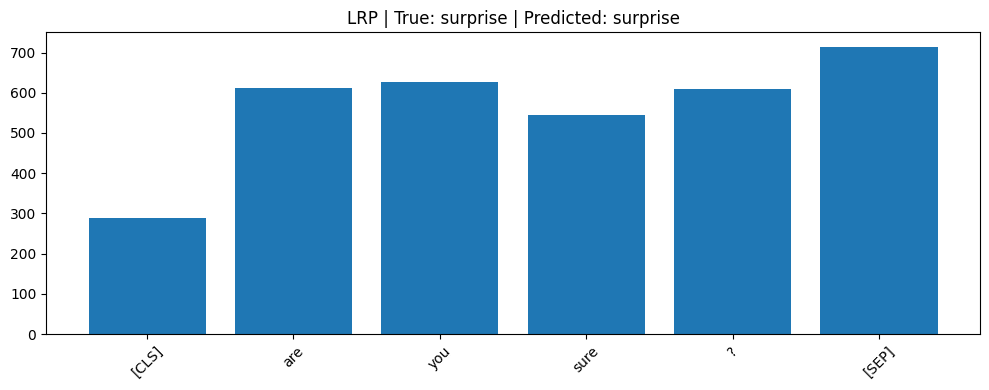

Sentence: Are you sure?
True Label: surprise
Predicted Label: surprise
--------------------------------------------------------------------------------


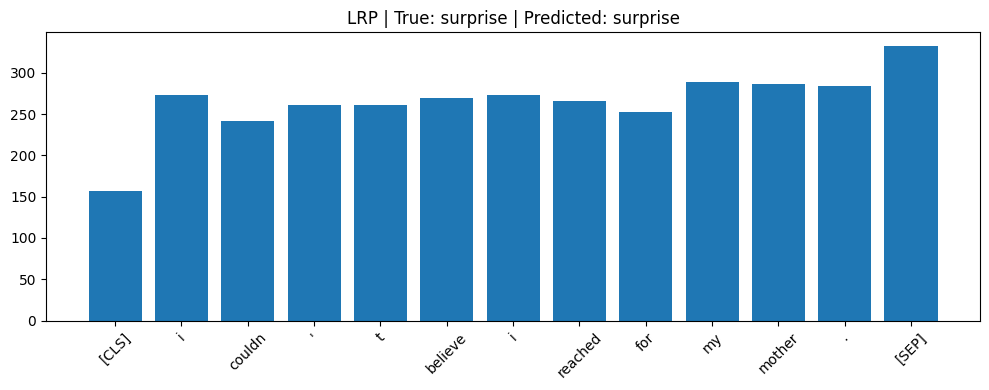

Sentence: I couldn't believe I reached for my mother.
True Label: surprise
Predicted Label: surprise
--------------------------------------------------------------------------------


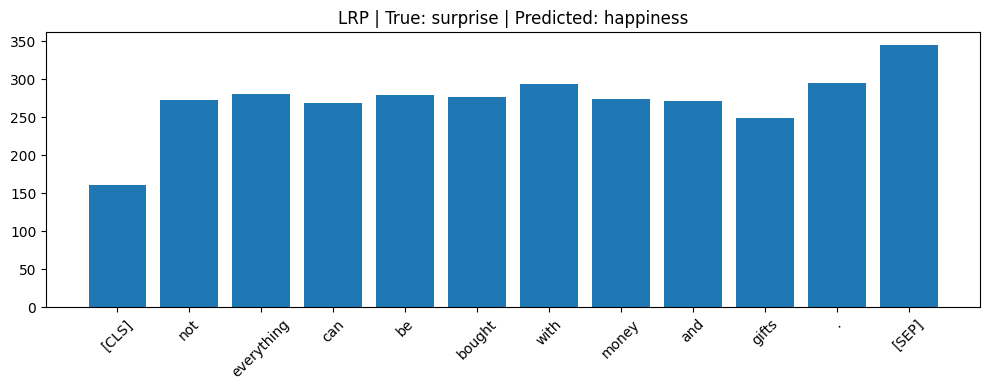

Sentence: Not everything can be bought with money and gifts.
True Label: surprise
Predicted Label: happiness
--------------------------------------------------------------------------------


In [8]:
# Run LRP and plot for all selected examples
for text, true_label in selected_examples:
    tokens, token_relevance, predicted_label, raw_text = lrp_conservative_propagation(model, tokenizer, text)

    # Plot relevance scores
    plt.figure(figsize=(10, 4))
    plt.bar(range(len(tokens)), token_relevance)
    plt.xticks(range(len(tokens)), tokens, rotation=45)
    plt.title(f"LRP | True: {true_label} | Predicted: {predicted_label}")
    plt.tight_layout()
    plt.show()

    print(f"Sentence: {raw_text}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_label}")
    print("-" * 80)

## Part 2 – Reflection on Conservative Propagation (Layer-wise Relevance Propagation)

In this part, we applied Layer-wise Relevance Propagation (LRP) using Conservative Propagation to better understand how our BERT model makes decisions when classifying emotions.

This approach allows us to trace back relevance through multiple layers of the model, taking into account how attention and normalization affect the flow of information. By detaching the attention softmax and LayerNorm scaling, relevance is more evenly and conservatively redistributed.

### What we observed:

- Compared to Gradient × Input, the LRP explanations appeared more **uniform across tokens**, especially for longer or more complex sentences.
- The model still highlighted meaningful words, but the **relevance was spread more gradually**, rather than being sharply focused on 1–2 standout tokens.
- In many cases, emotionally significant words still received high relevance, showing that the model was attending to the right features—even if it didn't always make the correct prediction.
- These explanations feel **more stable** and **less noisy** than those from Gradient × Input, making it easier to interpret the model’s decision process holistically.

### Summary:

Conservative Propagation via LRP offers a more complete and structured view of how the model processes emotional content. While not always as sharp or localized as Gradient × Input, LRP explanations better reflect how relevance travels through a Transformer’s architecture, leading to more interpretable and consistent results overall.

--------------------------------------------

# Part 3 – Model Robustness with Input Perturbation

In this final part, we evaluate how robust the model’s predictions are by progressively removing tokens and observing how its confidence changes.

We use the relevance scores generated by the LRP explanation method to guide the order of token removal. Tokens are removed starting with the **least relevant**, and after each removal step, we measure the model's confidence in its predicted class.

The resulting confidence curve helps us understand whether the model is relying heavily on just a few specific tokens or whether it is making decisions based on a more distributed understanding of the input.

In [9]:
# Perturbation function (removes least relevant tokens based on LRP scores)
def perturb_input_and_evaluate(model, tokenizer, inputs, relevance_scores, perturb_type='remove'):
    input_ids = inputs['input_ids'][0].clone()
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Sort token indices by relevance
    if perturb_type == 'remove':
        sorted_indices = torch.argsort(relevance_scores[0].norm(dim=-1), descending=False)
    else:
        sorted_indices = torch.argsort(relevance_scores[0].norm(dim=-1), descending=True)

    sorted_indices = sorted_indices.tolist()

    # Perturb input_ids directly by replacing with [PAD]
    perturbed_confidences = []
    for i in range(1, len(tokens) + 1):
        perturbed_ids = input_ids.clone()
        for idx in sorted_indices[:i]:
            if idx < len(perturbed_ids):
                perturbed_ids[idx] = tokenizer.pad_token_id
        perturbed_inputs = {
            'input_ids': perturbed_ids.unsqueeze(0),
            'attention_mask': inputs['attention_mask']
        }
        output = model(**perturbed_inputs)
        confidence = output.logits.softmax(dim=-1).max().item()
        perturbed_confidences.append(confidence)

    return perturbed_confidences

Sentence: Sofia. Lilyana Georgieva and her 13-year-old daughter Velina live in the B-5 residential complex.
True Label: neutral
Predicted Label: neutral
--------------------------------------------------------------------------------


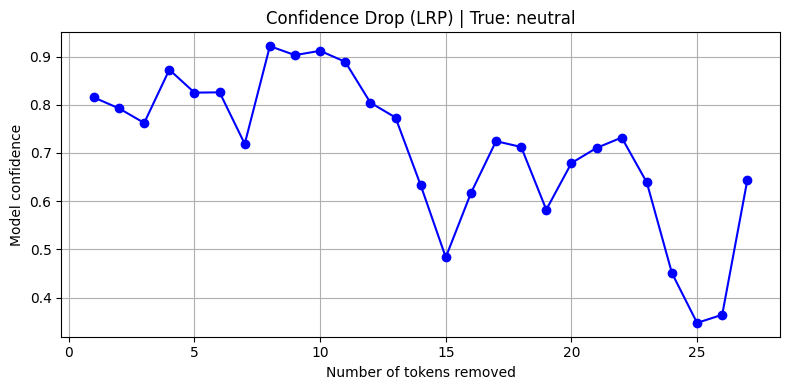

Sentence: Ever since Velina's father abandoned her family 6 years ago, the girl has been constantly pampered by her mother.
True Label: sadness
Predicted Label: happiness
--------------------------------------------------------------------------------


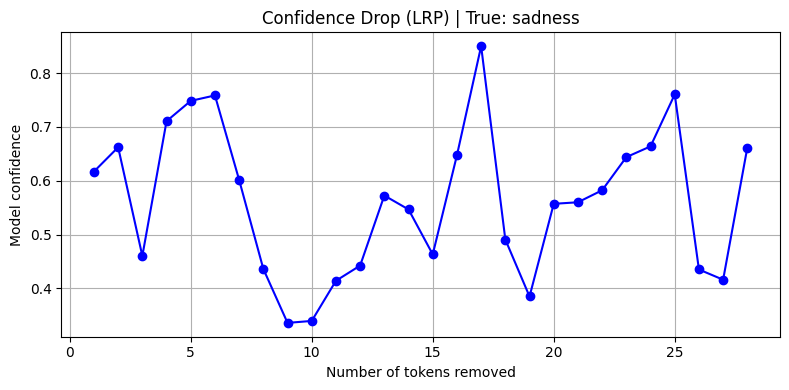

Sentence: There is almost no desire that Liliana does not fulfill her daughter.
True Label: happiness
Predicted Label: happiness
--------------------------------------------------------------------------------


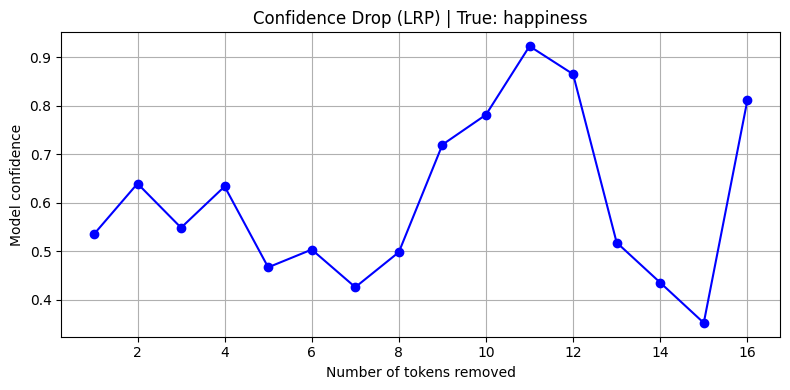

Sentence: The relationship between mother and daughter gets crazy when Liliana's new friend, Theodore, disadvantages to live with them,
True Label: anger
Predicted Label: happiness
--------------------------------------------------------------------------------


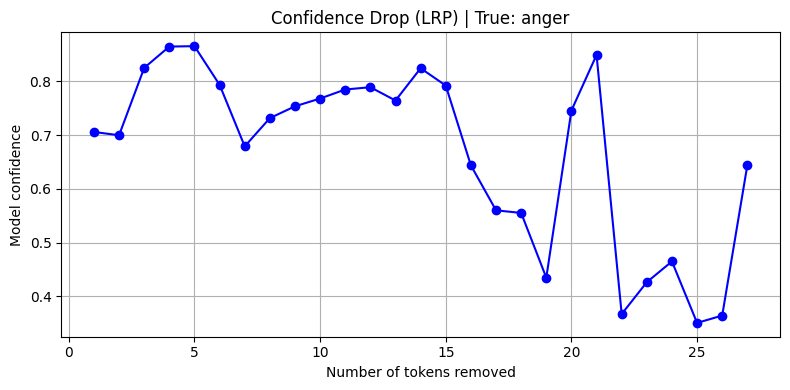

Sentence: I prefer to be left without money than to fight on the streets and not to watch.
True Label: fear
Predicted Label: happiness
--------------------------------------------------------------------------------


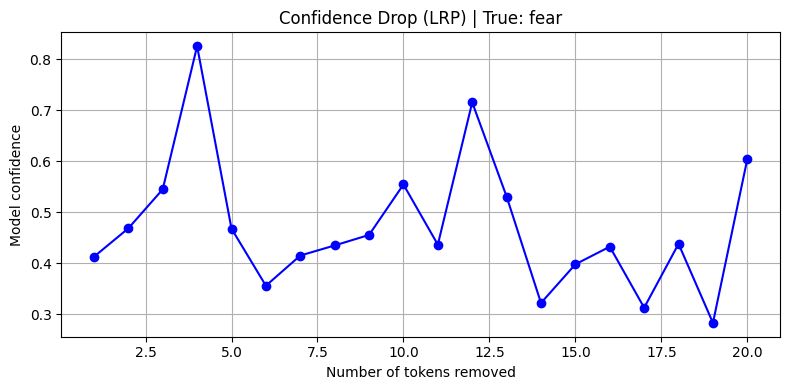

Sentence: She must stop retreating and explain to Little Liga that the world does not rotate around her.
True Label: disgust
Predicted Label: neutral
--------------------------------------------------------------------------------


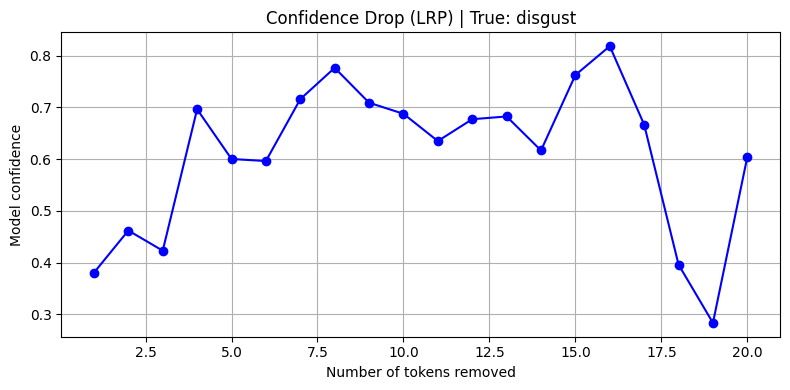

Sentence: Are you sure?
True Label: surprise
Predicted Label: surprise
--------------------------------------------------------------------------------


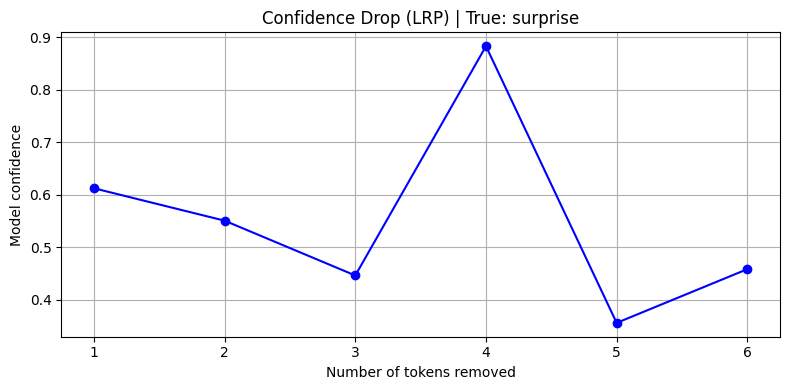

In [10]:
# Main loop for perturbation analysis and plotting
for text, true_label in selected_examples[::3]:  # 1 per emotion
    # Get true LRP relevance using the custom function
    inputs = tokenizer(text, return_tensors='pt')
    tokens, token_relevance, predicted_label, _ = lrp_conservative_propagation(model, tokenizer, text)

    # Turn 1D token relevance into fake 3D tensor (seq_len x hidden_dim)
    relevance_tensor = torch.tensor(token_relevance).unsqueeze(0).unsqueeze(-1).repeat(1, 1, model.config.hidden_size)

    # Run perturbation
    confidences = perturb_input_and_evaluate(model, tokenizer, inputs, relevance_tensor, perturb_type='remove')

    # Print info
    print(f"Sentence: {text}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_label}")
    print("-" * 80)

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(confidences) + 1), confidences, marker='o', color='blue')
    plt.title(f"Confidence Drop (LRP) | True: {true_label}")
    plt.xlabel("Number of tokens removed")
    plt.ylabel("Model confidence")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Part 3 – Model Robustness with Input Perturbation

In this part, we evaluated the model's robustness by applying **input perturbation** to progressively remove the least relevant tokens based on **Layer-wise Relevance Propagation (LRP)**. The aim was to track how the model’s confidence decreased as tokens were removed, providing insight into the model’s reliance on specific tokens for making predictions.

### Key Observations:

- **Confidence Drop Behavior**: 
    - In general, we observed both **sharp and gradual confidence drops** across the selected sentences. 
    - **Sharp drops** in confidence occurred after removing just a few tokens, indicating that the model might be highly dependent on a small set of critical tokens for its predictions.
    - **Gradual confidence decreases** suggest that the model relies more evenly on a broader context of tokens, maintaining relatively stable predictions even when several tokens were removed.

- **Emotion-Based Differences**: 
    - Sentences representing **emotions like anger** and **sadness** showed **steeper drops** in confidence after removing the least relevant tokens. This indicates that the model may rely on a few, highly influential tokens (likely emotionally significant words) to make its prediction.
    - Conversely, for sentences representing **emotions like fear** and **disgust**, confidence dropped more **gradually**, suggesting that the model uses a broader set of tokens, making it **more robust** to token removal.

### Conclusion:

- **Sharp Confidence Drops**: If the confidence drops sharply after removing a few tokens, the model likely **relies heavily** on specific, emotionally charged words for its decision-making.
- **Gradual Confidence Drops**: If confidence decreases gradually, the model is likely using a **more distributed set of tokens** for its predictions, which suggests **greater robustness** and less sensitivity to individual token changes.

### Insights:

- The analysis shows that the model’s **sensitivity to specific tokens** varies by emotion. Some emotions might be associated with **key emotional words**, while others seem to require a more **balanced understanding of the entire sentence**.
- This perturbation analysis helps us understand which parts of the input the model is **most sensitive to** and which it can afford to ignore, providing valuable insights into the model's **decision-making process**.